# Clamped square plate

In [24]:
from skfem import *
from skfem.visuals.matplotlib import *
%matplotlib inline
plt.set_cmap('plasma')

<Figure size 432x288 with 0 Axes>

0.7071067811865476

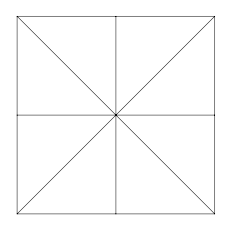

In [25]:
m = MeshTri.init_sqsymmetric()
import os
nrefs=int(os.environ.get("NREFS", 0))
m.refine(nrefs)
draw(m)
m.param()

In [26]:
e = ElementTriArgyris()
e.derivatives = 3
t = 1.
E = 1.
nu = 0.3
D = E * t ** 3 / (12. * (1. - nu ** 2))

def C(T):
    trT = T[0, 0] + T[1, 1]
    return E / (1. + nu) * \
        np.array([[T[0, 0] + nu / (1. - nu) * trT, T[0, 1]],
                  [T[1, 0], T[1, 1] + nu / (1. - nu) * trT]])

def K(ddu):
    return -ddu

def M(ddu):
    return t ** 3 / 12. * C(-ddu)

def divM(T): # input K
    trT1 = T[0, 0, 0] + T[1, 1, 0]
    trT2 = T[0, 0, 1] + T[1, 1, 1]
    return t ** 3 / 12 * E / (1. + nu) * \
        np.array([T[0, 0, 0] + nu / (1. - nu) * trT1 + T[0, 1, 1],
                  T[1, 0, 0] + T[1, 1, 1] + nu / (1. - nu) * trT2])

def gradM(T): # input K
    trT1 = T[0, 0, 0] + T[1, 1, 0]
    trT2 = T[0, 0, 1] + T[1, 1, 1]
    return t ** 3 / 12 * E / (1. + nu) * \
        np.array([[[T[0, 0, 0] + nu / (1. - nu) * trT1, T[0, 0, 1] + nu / (1. - nu) * trT2],
                   [T[0, 1, 0], T[0, 1, 1]]],
                  [[T[1, 0, 0], T[1, 0, 1]],
                   [T[1, 1, 0] + nu / (1. - nu) * trT1, T[1, 1, 1] + nu / (1. - nu) * trT2]]])

def Vn(dddu, n):
    from skfem.helpers import dot, ddot, dddot, prod
    s = n.copy()
    s[0] = n[1]
    s[1] = -n[0]
    return dot(divM(-dddu), n) + dddot(gradM(-dddu), prod(n, s, s))

def Mnn(ddu, n):
    from skfem.helpers import ddot, prod
    return ddot(M(ddu), prod(n, n))

def Mns(ddu, n):
    from skfem.helpers import ddot, prod
    s = n.copy()
    s[0] = n[1]
    s[1] = -n[0]
    return ddot(M(ddu), prod(n, s))

@BilinearForm
def bilinf(u, v, w):
    from skfem.helpers import ddot, dd
    return ddot(M(dd(u)), K(dd(v)))

@LinearForm
def linf(v, w):
    x, y = w.x
    return D * (8 * np.pi ** 4 * np.cos(np.pi * x) ** 2 * np.cos(np.pi * y) ** 2 \
                - 16 * np.pi ** 4 * np.cos(np.pi * y) ** 2 * np.sin(np.pi * x) ** 2 \
                - 16 * np.pi ** 4 * np.cos(np.pi * x) ** 2 * np.sin(np.pi * y) ** 2 \
                + 24 * np.pi ** 4 * np.sin(np.pi * x) ** 2 * np.sin(np.pi * y) ** 2 ) * v

gamma1 = 1e-3
gamma2 = gamma1
gamma3 = gamma1

@BilinearForm
def penalty_1(u, v, w):
    from skfem.helpers import d, ddd, dot
    return 1. / (gamma1 * w.h ** 3) * u * v\
           - Vn(ddd(u), w.n) * v - u * Vn(ddd(v), w.n)

@BilinearForm
def penalty_2(u, v, w):
    from skfem.helpers import d, dd, dot
    return 1. / (gamma2 * w.h) * dot(d(u), w.n) * dot(d(v), w.n)\
           + dot(d(u), w.n) * Mnn(dd(v), w.n) + Mnn(dd(u), w.n) * dot(d(v), w.n)

@BilinearForm
def penalty_3h(u, v, w):
    from skfem.helpers import d, dd, dot
    return (1. / (gamma3 * w.h ** 2) * u * v - Mns(dd(u), w.n) * v - Mns(dd(v), w.n) * u) / w.h \
        * (np.abs(w.x[0] - 0.5) == 0.5) * (np.abs(w.x[1] - 0.5) == 0.5)

@BilinearForm
def penalty_3v(u, v, w):
    from skfem.helpers import d, dd, dot
    return (0*Mns(dd(u), w.n) * v + Mns(dd(v), w.n) * u) / w.h \
        * (np.abs(w.x[0] - 0.5) == 0.5) * (np.abs(w.x[1] - 0.5) == 0.5)

basis = InteriorBasis(m, e)
fbasis = FacetBasis(m, e)
cbasis_h = FacetBasis(m, e,
                      facets=m.facets_satisfying(lambda x: np.abs(x[1] - 0.5) == 0.5),
                      quadrature=(np.array([[0.0, 1.0]]),
                                  np.array([1.0, 1.0])))
cbasis_v = FacetBasis(m, e,
                      facets=m.facets_satisfying(lambda x: np.abs(x[0] - 0.5) == 0.5),
                      quadrature=(np.array([[0.0, 1.0]]),
                                  np.array([1.0, 1.0])))

A = asm(bilinf, basis)
B1 = asm(penalty_1, fbasis)
B2 = asm(penalty_2, fbasis)
B3 = asm(penalty_3h, cbasis_h)
B4 = asm(penalty_3v, cbasis_v)
b = asm(linf, basis)

1.0058541512714387

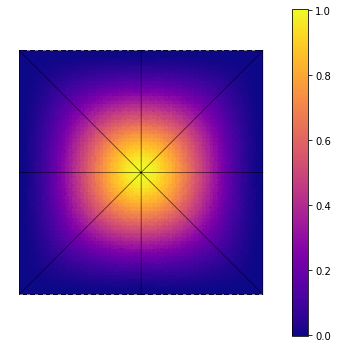

In [27]:
x = solve(A + B1 + B2 + B3 + B4, b)
ax = draw(m, figsize=(6, 6))
Nrefs = 5 if nrefs==0 else 4
plot(basis, x, Nrefs=Nrefs, colorbar=True, ax=ax)
np.max(x[basis.nodal_dofs[0]])

1.000041958696584

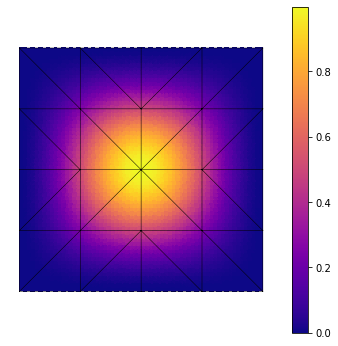

In [33]:
D = basis.find_dofs({
    'left': m.facets_satisfying(lambda x: (x[0]==0)*(x[1]<1)*(x[1]>0)),
    'up': m.facets_satisfying(lambda x: (x[1]==1)*(x[0]<1)*(x[0]>0)),
    'right': m.facets_satisfying(lambda x: (x[0]==1)*(x[1]<1)*(x[1]>0)),
    'down': m.facets_satisfying(lambda x: (x[1]==0)*(x[0]<1)*(x[0]>0)),
})

D1 = np.concatenate((
    D['left'].all(['u', 'u_x', 'u_y', 'u_yy', 'u_n']),
    D['right'].all(['u', 'u_x', 'u_y', 'u_yy', 'u_n']),
    D['up'].all(['u', 'u_x', 'u_y', 'u_xx', 'u_n']),
    D['down'].all(['u', 'u_x', 'u_y', 'u_xx', 'u_n']),
))

x = solve(*condense(A, b, D=D1))
ax = draw(m, figsize=(6, 6))
plot(basis, x, Nrefs=Nrefs, colorbar=True, ax=ax)
np.max(x[basis.nodal_dofs[0]])